# English-to-Cameroon pidgin english translation with a sequence-to-sequence Transformer

**Author:** [fchollet](https://twitter.com/fotie_codes)<br>
**Description:** Implementing a sequence-to-sequence Transformer and training it on a machine translation task.

## Introduction

In this example, we'll build a sequence-to-sequence Transformer model, which
we'll train on an English-to-Spanish machine translation task.

You'll learn how to:

- Vectorize text using the Keras `TextVectorization` layer.
- Implement a `TransformerEncoder` layer, a `TransformerDecoder` layer,
and a `PositionalEmbedding` layer.
- Prepare data for training a sequence-to-sequence model.
- Use the trained model to generate translations of never-seen-before
input sentences (sequence-to-sequence inference).

The code featured here is adapted from the book
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)
(chapter 11: Deep learning for text).
The present example is fairly barebones, so for detailed explanations of
how each building block works, as well as the theory behind Transformers,
I recommend reading the book.

## Setup

In [1]:
# We set the backend to TensorFlow. The code works with
# both `tensorflow` and `torch`. It does not work with JAX
# due to the behavior of `jax.numpy.tile` in a jit scope
# (used in `TransformerDecoder.get_causal_attention_mask()`:
# `tile` in JAX does not support a dynamic `reps` argument.
# You can make the code work in JAX by wrapping the
# inside of the `get_causal_attention_mask` method in
# a decorator to prevent jit compilation:
# `with jax.ensure_compile_time_eval():`.
import os
import pandas as pd

os.environ["KERAS_BACKEND"] = "tensorflow"

import pathlib
import random
import string
import re
import numpy as np

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras as keras
from keras import layers
#from keras import ops
from keras.layers import TextVectorization


## Downloading the data

We'll be working with an English-to-Spanish translation dataset
provided by [Anki](https://www.manythings.org/anki/). Let's download it:

In [2]:
import pandas as pd

data_file = "datasets/english_french.csv"
df = pd.read_csv(data_file)

In [3]:
print (df.head())

  English      French
0     Go.        Va !
1     Go.     Marche.
2     Go.  En route !
3     Go.     Bouge !
4     Hi.     Salut !


## Parsing the data

Each line contains an English sentence and its corresponding Spanish sentence.
The English sentence is the *source sequence* and Spanish one is the *target sequence*.
We prepend the token `"[start]"` and we append the token `"[end]"` to the Spanish sentence.

In [4]:
text_pairs = []
for index, row in df.iterrows():
    eng, fre = row['English'], row['French']
    fre = "[start] " + fre + " [end]"
    text_pairs.append((eng, fre))

Here's what our sentence pairs look like:

In [5]:
for _ in range(5):
    print(random.choice(text_pairs))

("We'll have plenty of time.", '[start] Nous aurons amplement le temps. [end]')
('All of us were soaking wet.', '[start] On était tous trempés. [end]')
('I want something better.', '[start] Je veux quelque chose de mieux. [end]')
('My university has a dormitory.', '[start] Mon université comporte un dortoir. [end]')
('I broke my right leg.', '[start] Je me suis cassé la jambe droite. [end]')


Now, let's split the sentence pairs into a training set, a validation set,
and a test set.

In [6]:
# Shuffle the text pairs to ensure randomness
random.shuffle(text_pairs)

# Calculate the number of validation samples as 15% of the total number of text pairs
num_val_samples = int(0.15 * len(text_pairs))

# Calculate the number of training samples as the total number of text pairs minus twice the number of validation samples
num_train_samples = len(text_pairs) - 2 * num_val_samples

# Split the text pairs into training, validation, and test sets
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

# Print the number of total, training, validation, and test pairs
print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

229803 total pairs
160863 training pairs
34470 validation pairs
34470 test pairs


## Vectorizing the text data

We'll use two instances of the `TextVectorization` layer to vectorize the text
data (one for English and one for Spanish),
that is to say, to turn the original strings into integer sequences
where each integer represents the index of a word in a vocabulary.

The English layer will use the default string standardization (strip punctuation characters)
and splitting scheme (split on whitespace), while
the Spanish layer will use a custom standardization, where we add the character
`"¿"` to the set of punctuation characters to be stripped.

Note: in a production-grade machine translation model, I would not recommend
stripping the punctuation characters in either language. Instead, I would recommend turning
each punctuation character into its own token,
which you could achieve by providing a custom `split` function to the `TextVectorization` layer.

In [7]:
# Define a string of characters to be stripped from the input, including all punctuation and the "¿" character
strip_chars = string.punctuation + "¿"
# Remove the "[" and "]" characters from the strip_chars string
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

# Define the vocabulary size, sequence length, and batch size
vocab_size = 15000
sequence_length = 20
batch_size = 64

# Define a function to standardize the input string
def custom_standardization(input_string):
    # Convert the input string to lowercase
    lowercase = tf_strings.lower(input_string)
    # Replace all characters in the strip_chars string with an empty string
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Define a TextVectorization layer for the English texts
eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Define a TextVectorization layer for the Spanish texts, with custom standardization
fre_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

# Extract the English and Spanish texts from the training pairs
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]

# Adapt the TextVectorization layers to the training texts
eng_vectorization.adapt(train_eng_texts)
fre_vectorization.adapt(train_spa_texts)

2024-01-09 09:57:18.302311: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-09 09:57:18.302336: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-09 09:57:18.302345: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-09 09:57:18.302377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-09 09:57:18.302392: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Next, we'll format our datasets.

At each training step, the model will seek to predict target words N+1 (and beyond)
using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.
`encoder_inputs` is the vectorized source sentence and `encoder_inputs` is the target sentence "so far",
that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.
- `target` is the target sentence offset by one step:
it provides the next words in the target sentence -- what the model will try to predict.

In [8]:
# Define a function to format the dataset
def format_dataset(eng, spa):
    # Vectorize the English and Spanish texts
    eng = eng_vectorization(eng)
    spa = fre_vectorization(spa)
    # Return a dictionary with the encoder inputs and decoder inputs, and the target sequences
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": spa[:, :-1],
        },
        spa[:, 1:],
    )

# Define a function to create a dataset from a list of pairs
def make_dataset(pairs):
    # Unzip the pairs into two lists of English and Spanish texts
    eng_texts, spa_texts = zip(*pairs)
    # Convert the lists to tensors
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    # Create a dataset from the tensors
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    # Batch the dataset
    dataset = dataset.batch(batch_size)
    # Map the format_dataset function to the dataset
    dataset = dataset.map(format_dataset)
    # Cache, shuffle, and prefetch the dataset
    return dataset.cache().shuffle(2048).prefetch(16)

# Create datasets for the training and validation pairs
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Let's take a quick look at the sequence shapes
(we have batches of 64 pairs, and all sequences are 20 steps long):

In [9]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"].shape: (64, 20)
targets.shape: (64, 20)


2024-01-09 09:57:20.657588: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Building the model

Our sequence-to-sequence Transformer consists of a `TransformerEncoder`
and a `TransformerDecoder` chained together. To make the model aware of word order,
we also use a `PositionalEmbedding` layer.

The source sequence will be pass to the `TransformerEncoder`,
which will produce a new representation of it.
This new representation will then be passed
to the `TransformerDecoder`, together with the target sequence so far (target words 0 to N).
The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).

A key detail that makes this possible is causal masking
(see method `get_causal_attention_mask()` on the `TransformerDecoder`).
The `TransformerDecoder` sees the entire sequences at once, and thus we must make
sure that it only uses information from target tokens 0 to N when predicting token N+1
(otherwise, it could use information from the future, which would
result in a model that cannot be used at inference time).

In [10]:
import keras.ops as ops


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
            padding_mask = ops.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config


Next, we assemble the end-to-end model.

In [11]:
embed_dim = 256
latent_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [12]:
from keras.utils import plot_model
plot_model(decoder, to_file='decoder_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Training our model

We'll use accuracy as a quick way to monitor training progress on the validation data.
Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

Here we only train for 1 epoch, but to get the model to actually converge
you should train for at least 30 epochs.

In [15]:
epochs = 1  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[callback])

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ positional_embeddi… │ (None, None, 256) │ 3,845,… │ encoder_inputs[0][0] │
│ (PositionalEmbeddi… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ decoder_inputs      │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ transformer_encoder │ (None, None, 256) │ 3,155,… │ positional_embeddin… │
│ (TransformerEncode… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ functional_5        │ (None, None,      │ 12,959… │ decoder_inputs[0][0… │
│ (Functional)        │ 15000)            │         │ transformer_encoder… │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 39,920,434 (152.28 MB)

 Trainable params: 19,960,216 (76.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,960,218 (76.14 MB)

2514/2514 ━━━━━━━━━━━━━━━━━━━━ 1362s 540ms/step - accuracy: 0.7281 - loss: 1.6458 - val_accuracy: 0.7366 - val_loss: 1.5403


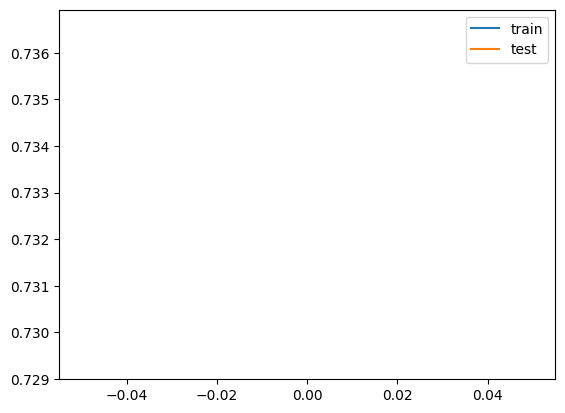

In [19]:
# plot accuracy and all the rest so we see if the model is learning or not
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## Decoding test sentences

Finally, let's demonstrate how to translate brand new English sentences.
We simply feed into the model the vectorized English sentence
as well as the target token `"[start]"`, then we repeatedly generated the next token, until
we hit the token `"[end]"`.

In [20]:
fre_vocab = fre_vectorization.get_vocabulary()
fre_index_lookup = dict(zip(range(len(fre_vocab)), fre_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = fre_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = fre_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(5):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(f"Input sentence: {input_sentence}")
    print(f"Translated:     {translated}")

Input sentence: I don't want to do this again.
Translated:     [start] je suis sûr que tom est en train de faire ça [end]
Input sentence: I don't make the rules.
Translated:     [start] je suis sûr que tom est en train de faire ça [end]
Input sentence: I'm trying to understand it.
Translated:     [start] je suis sûr que tom est en train de faire ça [end]
Input sentence: I've been to neither of those places.
Translated:     [start] je suis sûr que tom est en train de faire ça [end]
Input sentence: I have a castle.
Translated:     [start] je suis sûr que tom est en train de faire ça [end]
